# **Multi-Layer Perceptron (MLP) for MNIST Digit Recognition**

This notebook implements an MLP for MNIST digit classification, using PyTorch for data loading but NumPy for the core MLP implementation. It covers data loading, network architecture, training with backpropagation and momentum, and performance evaluation.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # Included for consistency, though not directly used in this notebook

np.random.seed(42)  # For reproducibility

# **1. MNIST Dataset Description**

The MNIST (Modified National Institute of Standards and Technology) dataset is a large database of handwritten digits commonly used for training image processing systems. It consists of 60,000 training images and 10,000 testing images. Each image is a grayscale, 28x28 pixel representation of a handwritten digit from 0 to 9. This makes it a multi-class classification problem with 10 distinct output classes.

The task is to classify these images into their corresponding digit categories. The dataset is widely used for benchmarking classification algorithms due to its relatively simple structure and clear separation of classes, while still posing a non-trivial challenge for basic models.

# **2. MNIST Data Functions**

Functions for loading and visualizing the MNIST dataset.

In [ ]:
def mnist_load(classes, Ntrain=None):
    """
    Loads MNIST data for specified classes using PyTorch.
    Optionally limits training set size.
    """
    import torch
    import torchvision
    from torchvision import datasets, transforms

    # Define a transformation to convert images to tensors and normalize
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

    # Load the training and test datasets
    train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

    # Initialize empty lists to hold the data
    Xtrain_list = []
    ytrain_list = []
    Xtest_list = []
    ytest_list = []

    # Process training data
    for img, label in train_dataset:
        if label in classes:
            Xtrain_list.append(img.numpy().flatten())
            ytrain_list.append(label)

    # Process testing data
    for img, label in test_dataset:
        if label in classes:
            Xtest_list.append(img.numpy().flatten())
            ytest_list.append(label)

    # Convert lists to NumPy arrays
    Xtrain = np.array(Xtrain_list)
    ytrain = np.array(ytrain_list)
    Xtest = np.array(Xtest_list)
    ytest = np.array(ytest_list)

    if Ntrain is not None:
        Xtrain = Xtrain[:Ntrain]
        ytrain = ytrain[:Ntrain]

    return Xtrain, ytrain, Xtest, ytest

def display_mnist(X, example_width=None):
    """
    Displays 2D data (MNIST digits) in a grid.
    """
    if example_width is None:
        example_width = int(np.round(np.sqrt(X.shape[1])))

    plt.set_cmap('gray')
    m, n = X.shape
    example_height = n // example_width
    display_rows = int(np.floor(np.sqrt(m)))
    display_cols = int(np.ceil(m / display_rows))
    pad = 1

    display_array = -np.ones(
        (pad + display_rows * (example_height + pad),
         pad + display_cols * (example_width + pad))
    )

    curr_ex = 0
    for j in range(display_rows):
        for i in range(display_cols):
            if curr_ex >= m:
                break
            max_val = np.max(np.abs(X[curr_ex, :]))

            # Corrected slicing for display_array to match reshaped image dimensions
            display_array[
                pad + j * (example_height + pad) : pad + j * (example_height + pad) + example_height,
                pad + i * (example_width + pad) : pad + i * (example_width + pad) + example_width
            ] = X[curr_ex, :].reshape(example_height, example_width) / max_val
            curr_ex += 1
        if curr_ex >= m:
            break

    plt.imshow(display_array)
    plt.axis('off')
    plt.show()

# **3. MLP Core Functions**

Essential functions for MLP: activation, cost, weight initialization, forward pass, backpropagation, and label encoding.

## **3.1 Activation and Cost Functions**
* **Sigmoid Activation:** Used in the hidden layer to introduce non-linearity.
    $$ \sigma(z) = \frac{1}{1 + e^{-z}} $$
* **Sigmoid Derivative:** Crucial for backpropagation.
    $$ \sigma'(z) = \sigma(z)(1 - \sigma(z)) $$
* **Binary Cross-Entropy (BCE) Cost:** Used for multi-class classification with one-hot encoded labels and sigmoid output activation. For a single sample $p$ and class $c$:
    $$ L(y_{true,c}, \hat{y}_c) = -y_{true,c} \, \log(\hat{y}_c) - (1 - y_{true,c}) \, \log(1 - \hat{y}_c) $$
    The total cost for a batch is the sum over all samples and classes.
* **L1 Regularization:** $R_{L1}(\mathbf{W}) = \frac{\lambda}{2} \sum_{j} |w_j|$
* **L2 Regularization:** $R_{L2}(\mathbf{W}) = \frac{\lambda}{2} \sum_{j} w_j^2$

## **3.2 Forward Pass**
Computes network output $\hat{Y}$ from input $X$:
1.  Augment input $X$ with bias to get $A_0$.
2.  Hidden layer pre-activation: $Z_1 = A_0 W_1^T$
3.  Hidden layer activation: $A_1 = \sigma(Z_1)$
4.  Augment $A_1$ with bias.
5.  Output layer pre-activation: $Z_2 = A_1^{ext} W_2^T$
6.  Output layer activation (prediction): $\hat{Y} = \sigma(Z_2)$

## **3.3 Backpropagation**
Calculates gradients for weight updates:
1.  Output layer error: $\delta_2 = \hat{Y} - Y_{true}$ (where $Y_{true}$ is one-hot encoded)
2.  Gradient for $W_2$: $\nabla_{W_2} J = \delta_2^T A_1^{ext}$
3.  Hidden layer error: $\delta_1 = (\delta_2 W_2)_{\text{excluding bias}} \odot \sigma'(Z_1)$
4.  Gradient for $W_1$: $\nabla_{W_1} J = \delta_1^T A_0$

In [ ]:
def MLP_sigmoid(z):
    """Sigmoid activation function."""
    return 1.0 / (1.0 + np.exp(-z))

def MLP_sigmoid_gradient(Z):
    """Derivative of the sigmoid function."""
    sig = MLP_sigmoid(Z)
    return sig * (1 - sig)

def MLP_initialize_weights(model):
    """Initializes MLP weights uniformly in [-1, 1]."""
    n_hidden = model['n_hidden']
    n_features = model['n_features']
    n_output = model['n_output']
    W1 = 2 * np.random.rand(n_hidden, n_features + 1) - 1
    W2 = 2 * np.random.rand(n_output, n_hidden + 1) - 1
    return W1, W2

def encode_labels(y, k):
    """One-hot encodes labels."""
    onehot = np.zeros((k, len(y)))
    for i, val in enumerate(y):
        onehot[val, i] = 1  # Assuming y are 0-indexed classes
    return onehot

def L1_reg(lambda_reg, W1, W2):
    """Computes L1 regularization cost."""
    return (lambda_reg / 2) * (np.sum(np.abs(W1[:, 1:])) + np.sum(np.abs(W2[:, 1:])))

def L2_reg(lambda_reg, W1, W2):
    """Computes L2 regularization cost."""
    return (lambda_reg / 2) * (np.sum(W1[:, 1:]**2) + np.sum(W2[:, 1:]**2))

def MLP_BCESIG_forward(X, W1, W2):
    """
    Performs forward pass through MLP with sigmoid output.
    Returns: rA2 (output activations), A1 (hidden activations + bias),
             A0 (input + bias), rZ1 (hidden pre-activations).
    """
    batch_size = X.shape[0]
    A0 = np.hstack((np.ones((batch_size, 1)), X)) # (batch_size, n_features + 1)

    rZ1 = A0 @ W1.T # (batch_size, n_hidden)
    A1 = MLP_sigmoid(rZ1) # (batch_size, n_hidden)
    A1 = np.hstack((np.ones((batch_size, 1)), A1)) # (batch_size, n_hidden + 1)

    rZ2 = A1 @ W2.T # (batch_size, n_output)
    rA2 = MLP_sigmoid(rZ2) # Output layer uses sigmoid for classification

    return rA2, A1, A0, rZ1, rZ2 # rZ2 added for clarity in backprop

def get_BCE_cost(y_enc, y_pred, model, W1, W2):
    """
    Computes Binary Cross-Entropy cost with regularization.
    y_enc: one-hot encoded true labels (n_output, batch_size)
    y_pred: predicted probabilities (batch_size, n_output)
    """
    # Ensure y_pred is clipped to avoid log(0) issues
    y_pred = np.clip(y_pred, 1e-12, 1 - 1e-12)

    term1 = -y_enc * np.log(y_pred.T) # Transpose y_pred to match y_enc shape
    term2 = (1 - y_enc) * np.log(1 - y_pred.T)
    cost = np.sum(term1 - term2) # Sum across classes and patterns

    L1_term = L1_reg(model['l1'], W1, W2)
    L2_term = L2_reg(model['l2'], W1, W2)
    cost = cost + L1_term + L2_term
    return cost

def get_BCESIG_gradient(rA2, A1, A0, rZ1, rZ2, Y_enc, W1, W2, l1, l2):
    """
    Computes gradients via backpropagation for BCE loss and sigmoid output.
    rA2: output activations (batch_size, n_output)
    A1: hidden activations + bias (batch_size, n_hidden + 1)
    A0: input + bias (batch_size, n_features + 1)
    rZ1: hidden pre-activations (batch_size, n_hidden)
    rZ2: output pre-activations (batch_size, n_output)
    Y_enc: one-hot encoded true labels (n_output, batch_size)
    """
    # Step 1: Compute dL_dZ2 (error signal at output layer pre-activation)
    # For BCE with sigmoid output, dL/dZ2 = (rA2 - Y_enc.T)
    dL_dZ2 = rA2 - Y_enc.T # (batch_size, n_output)

    # Step 2: Compute dL_dW2 (gradient for W2)
    dL_dW2 = dL_dZ2.T @ A1 # (n_output, n_hidden + 1)

    # Step 3: Compute dL_dA1 (error signal propagated back to hidden layer activations)
    dL_dA1 = dL_dZ2 @ W2 # (batch_size, n_hidden + 1)

    # Step 4: Compute dL_drZ1 (error signal at hidden layer pre-activation)
    # Exclude bias term from dL_dA1 and multiply by sigmoid derivative of hidden layer
    sigma_prime_of_rZ1 = MLP_sigmoid_gradient(rZ1)
    dL_drZ1 = dL_dA1[:, 1:] * sigma_prime_of_rZ1 # (batch_size, n_hidden)

    # Step 5: Compute dL_dW1 (gradient for W1)
    dL_dW1 = dL_drZ1.T @ A0 # (n_hidden, n_features + 1)

    # Step 6: Add regularization terms to gradients (for non-bias weights)
    delta_W1_unscaled = dL_dW1
    delta_W2_unscaled = dL_dW2

    delta_W1_unscaled[:, 1:] += W1[:, 1:] * (l1 + l2) # L1/L2 on non-bias weights
    delta_W2_unscaled[:, 1:] += W2[:, 1:] * (l1 + l2) # L1/L2 on non-bias weights

    return delta_W1_unscaled, delta_W2_unscaled

def MLP_BCESIG_predict(X, W1, W2):
    """
    Predicts class labels for input X.
    Returns 0-indexed class labels.
    """
    rA2, _, _, _, _ = MLP_BCESIG_forward(X, W1, W2)
    y_pred = np.argmax(rA2, axis=1) # Get the class with highest probability
    return y_pred


# **4. MLP Training Loop**

The main function to train the MLP using mini-batch Gradient Descent with momentum and adaptive learning rate.

In [ ]:
def MLP_BCESIG_train(X_train, y_train, model):
    """
    Trains the MLP model for classification.
    """
    W1, W2 = MLP_initialize_weights(model)
    l1 = model['l1']
    l2 = model['l2']
    eta = model['eta']
    alpha = model['alpha']
    epochs = model['epochs']
    n_output = model['n_output']
    minibatches = model['minibatches']
    decrease_const = model['decrease_const']

    y_enc = encode_labels(y_train, n_output) # One-hot encode all training labels

    delta_W1_prev = np.zeros_like(W1)
    delta_W2_prev = np.zeros_like(W2)
    model['cost_history'] = []

    num_observations = X_train.shape[0]

    for e in range(1, epochs + 1):
        print(f'Epoch: {e}')

        current_eta = eta / (1 + decrease_const * e) # Adaptive learning rate

        # Shuffle data for mini-batching
        shuffled_indices = np.random.permutation(num_observations)
        X_shuffled = X_train[shuffled_indices, :]
        y_enc_shuffled = y_enc[:, shuffled_indices]

        # Calculate actual mini-batch size and number of full mini-batches
        batch_size_per_minibatch = num_observations // minibatches

        for m_idx in range(minibatches):
            start_idx = m_idx * batch_size_per_minibatch
            end_idx = start_idx + batch_size_per_minibatch

            X_mini_batch = X_shuffled[start_idx:end_idx, :]
            y_enc_mini_batch = y_enc_shuffled[:, start_idx:end_idx]

            # Forward pass
            rA2, A1, A0, rZ1, rZ2 = MLP_BCESIG_forward(X_mini_batch, W1, W2)

            # Compute cost
            cost = get_BCE_cost(y_enc_mini_batch, rA2, model, W1, W2)
            model['cost_history'].append(cost)

            # Compute gradient via backpropagation
            delta_W1_unscaled, delta_W2_unscaled = get_BCESIG_gradient(
                rA2, A1, A0, rZ1, rZ2, y_enc_mini_batch, W1, W2, l1, l2
            )

            # Update parameters with momentum
            delta_W1 = current_eta * delta_W1_unscaled
            delta_W2 = current_eta * delta_W2_unscaled

            W1 = W1 - (delta_W1 + (alpha * delta_W1_prev))
            W2 = W2 - (delta_W2 + (alpha * delta_W2_prev))

            delta_W1_prev = delta_W1
            delta_W2_prev = delta_W2

    model['W1'] = W1
    model['W2'] = W2
    return model, W1, W2


# **5. Main Script: Training and Evaluation**

Sets up parameters, loads data, trains the MLP, and evaluates its performance on training and test sets.

100%|██████████| 9.91M/9.91M [00:00<00:00, 53.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.84MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.8MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.64MB/s]


Displaying a sample of MNIST training digits:


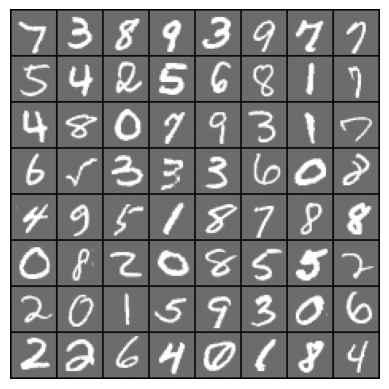


Starting MLP training on MNIST dataset...
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
MLP training complete.

Training accuracy: 94.03%
Test accuracy: 93.02%


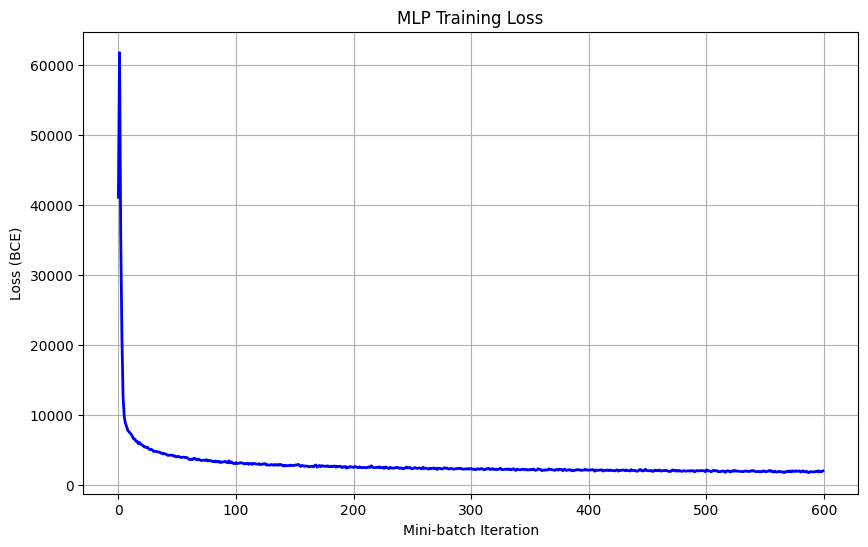

In [ ]:
plt.close('all') # Close all matplotlib figures

# Parameters
classes = list(range(10)) # Digits 0-9
Ntrain = 60000            # Number of training patterns
Ntest  = 10000            # Number of test patterns

# Load Data
Xtrain, ytrain, Xtest, ytest = mnist_load(classes, Ntrain)

# Display a sample of training images
print("Displaying a sample of MNIST training digits:")
idx = np.random.permutation(Xtrain.shape[0])[:64]
display_mnist(Xtrain[idx, :])

# Model Parameters
model = {
    'n_output': len(classes),  # Number of output classes (10 for MNIST)
    'n_features': Xtrain.shape[1], # Number of input features (28*28 = 784)
    'n_hidden': 50,            # Number of neurons in the hidden layer
    'l1': 0,                   # L1 regularization weight
    'l2': 0.1,                 # L2 regularization weight
    'epochs': 30,              # Number of training epochs
    'eta': 0.001,              # Learning rate
    'alpha': 0.001,            # Momentum coefficient
    'decrease_const': 0.00001, # Adaptive learning rate constant
    'minibatches': 20,         # Number of mini-batches per epoch
}

# Train MLP
print("\nStarting MLP training on MNIST dataset...")
model_trained, W1_trained, W2_trained = MLP_BCESIG_train(Xtrain, ytrain, model)
print("MLP training complete.")

# Predictions
ytrain_pred = MLP_BCESIG_predict(Xtrain, W1_trained, W2_trained)
ytest_pred  = MLP_BCESIG_predict(Xtest,  W1_trained, W2_trained)

# Compute and display accuracy
acc_train = np.sum(ytrain == ytrain_pred) / Xtrain.shape[0]
print(f'\nTraining accuracy: {acc_train * 100:.2f}%')

acc_test = np.sum(ytest == ytest_pred) / Xtest.shape[0]
print(f'Test accuracy: {acc_test * 100:.2f}%')

# Plot Training Loss
plt.figure(figsize=(10, 6))
plt.plot(model_trained['cost_history'], color='blue', linewidth=2)
plt.title('MLP Training Loss')
plt.xlabel('Mini-batch Iteration')
plt.ylabel('Loss (BCE)')
plt.grid(True)
plt.show()
